# **Medical training platform project’s data analysis**

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [46]:
# Exploring the dataset
df = pd.read_csv('medical_conditions_dataset.csv')  # Cambia 'data.csv' por el nombre de tu archivo si es diferente

# show the first few rows and info about the dataset
display(df.head())
df.info()

,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia
1,2,User0002,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic
2,3,User0003,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia
3,4,User0004,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia
4,5,User0005,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   full_name       10000 non-null  object 
 2   age             5445 non-null   float64
 3   gender          10000 non-null  object 
 4   smoking_status  10000 non-null  object 
 5   bmi             4652 non-null   float64
 6   blood_pressure  3766 non-null   float64
 7   glucose_levels  4756 non-null   float64
 8   condition       10000 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 703.2+ KB


## *Distribution medical Conditions*

Distribution of medical conditions (%):
condition
Diabetic     60.13
Pneumonia    25.27
Cancer       14.60
Name: proportion, dtype: float64


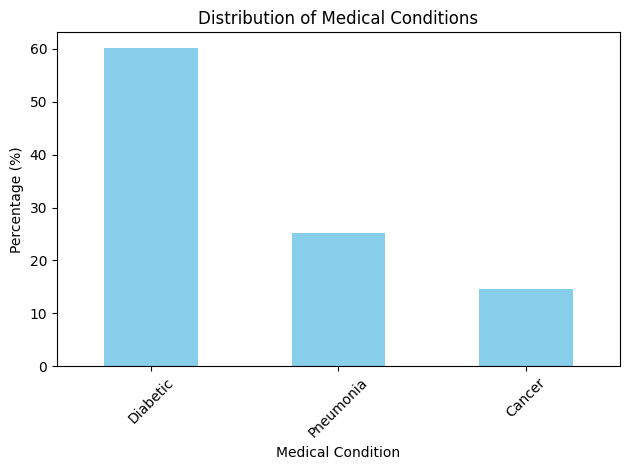

In [47]:
# Distribution of medical conditions
condition_counts = df['condition'].value_counts(normalize=True) * 100
print("Distribution of medical conditions (%):")
print(condition_counts)

# Plotting the distribution
condition_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Medical Conditions')
plt.xlabel('Medical Condition')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## *Relation Age vs Condition*

In [48]:
# Handle nulls (example: fill with mean per condition)
df['age'] = df.groupby('condition')['age'].transform(lambda x: x.fillna(x.mean()))

# One-hot encode conditions
df_encoded = pd.get_dummies(df, columns=['condition'], drop_first=False)

# Define custom bins and labels
bins = [0, 18, 35, 50, 65, df['age'].max()]
labels = ['0-18', '19-35', '36-50', '51-65', '66+']

# Create age_group column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)


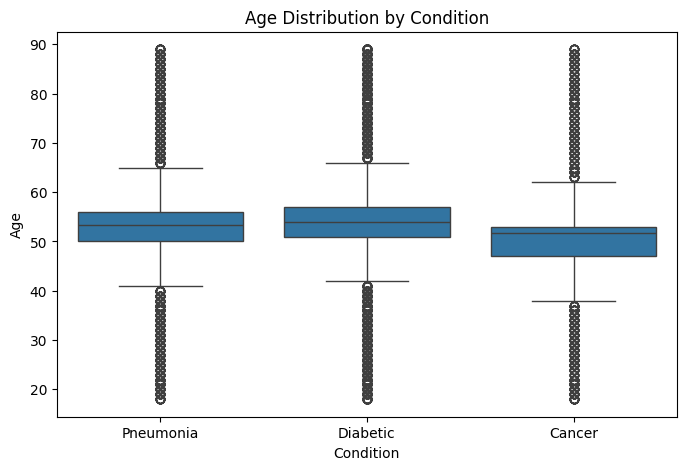

In [49]:
plt.figure(figsize=(8,5))
sns.boxplot(x='condition', y='age', data=df)
plt.title("Age Distribution by Condition")
plt.xlabel("Condition")
plt.ylabel("Age")
plt.show()

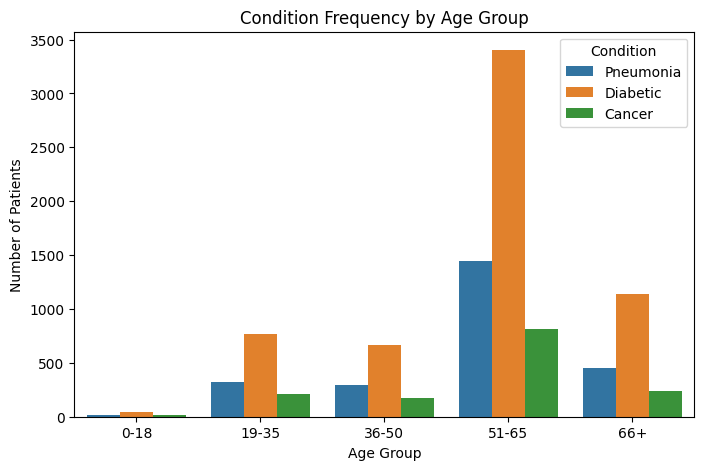

In [50]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', hue='condition', data=df)
plt.title("Condition Frequency by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.legend(title="Condition")
plt.show()

## *Blood Pressure vs Glucoce Levels*

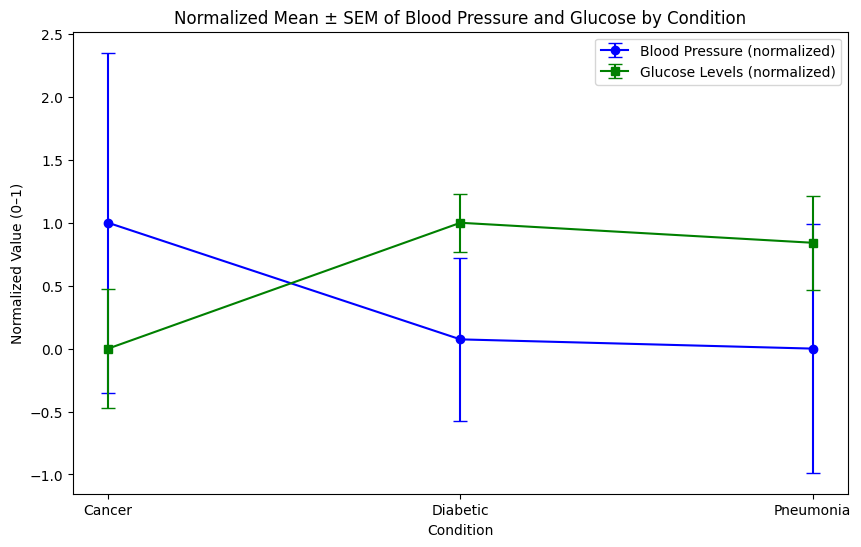

In [51]:


# 1. Group by condition and calculate mean & SEM (standard error of the mean)
summary = df.groupby('condition')[['blood_pressure', 'glucose_levels']].agg(['mean', 'sem'])

# 2. Normalize mean and SEM to 0–1 scale for comparability
for col in ['blood_pressure', 'glucose_levels']:
    # Normalize means
    min_val = summary[col]['mean'].min()
    max_val = summary[col]['mean'].max()
    summary[col, 'mean_norm'] = (summary[col]['mean'] - min_val) / (max_val - min_val)

    # Normalize SEM with the same scale
    summary[col, 'sem_norm'] = summary[col]['sem'] / (max_val - min_val)

# 3. Plot normalized values with SEM error bars
plt.figure(figsize=(10,6))

# Blood Pressure
plt.errorbar(
    summary.index,
    summary['blood_pressure']['mean_norm'],
    yerr=summary['blood_pressure']['sem_norm'],
    fmt='-o',
    capsize=5,
    label='Blood Pressure (normalized)',
    color='blue'
)

# Glucose Levels
plt.errorbar(
    summary.index,
    summary['glucose_levels']['mean_norm'],
    yerr=summary['glucose_levels']['sem_norm'],
    fmt='-s',
    capsize=5,
    label='Glucose Levels (normalized)',
    color='green'
)

# Labels and title
plt.title("Normalized Mean ± SEM of Blood Pressure and Glucose by Condition")
plt.xlabel("Condition")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.show()


## Building a Classification Model

We implement a Random Forest Classifier to predict medical conditions, supporting the DSS by providing feedback on diagnostic accuracy.

Classification Report:
              precision    recall  f1-score   support

      Cancer       0.88      0.78      0.82       292
    Diabetic       0.88      0.94      0.91      1203
   Pneumonia       0.88      0.81      0.84       505

    accuracy                           0.88      2000
   macro avg       0.88      0.84      0.86      2000
weighted avg       0.88      0.88      0.88      2000



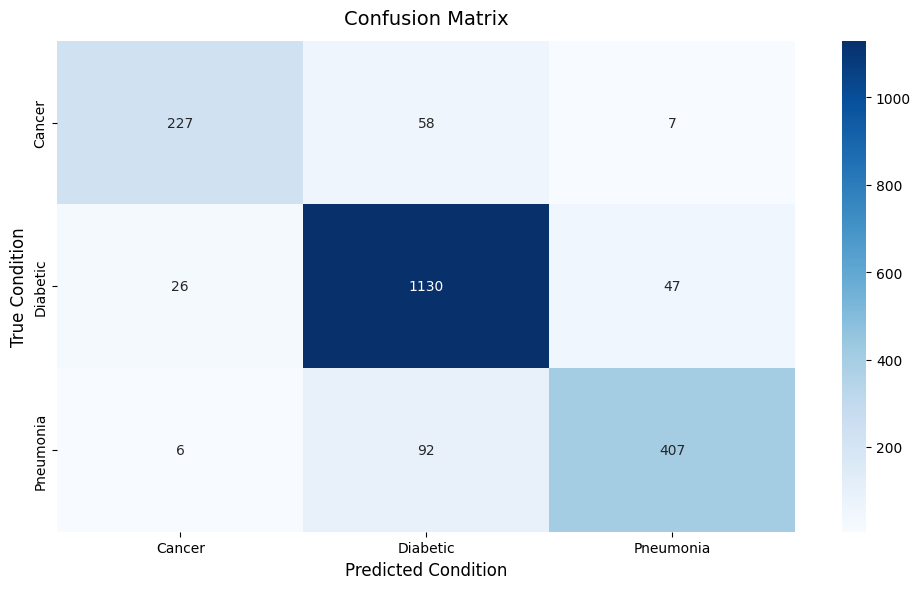

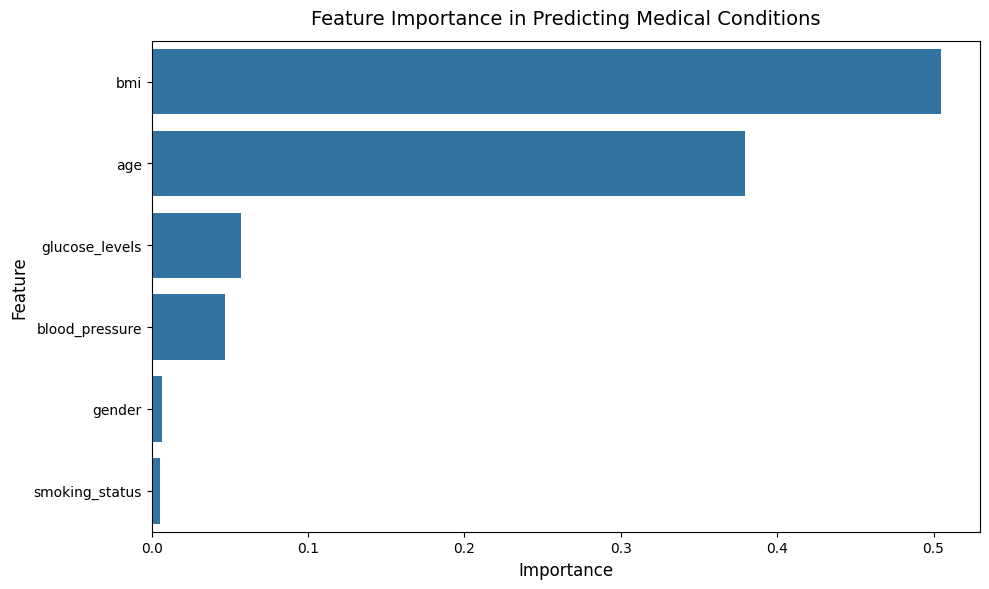


Class mapping (encoded -> original):
0 -> Cancer
1 -> Diabetic
2 -> Pneumonia


In [52]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

num_cols = ['age', 'bmi', 'blood_pressure', 'glucose_levels']
cat_cols = ['gender', 'smoking_status']
target_col = 'condition'
features = ['age', 'gender', 'smoking_status', 'bmi', 'blood_pressure', 'glucose_levels']

# Keep only needed columns if there are extras
keep_cols = [c for c in ['id', 'full_name'] + features + [target_col] if c in df.columns]
df = df[keep_cols].copy()


for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

# Ensure numeric cols are numeric
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Impute BMI per condition (median), then global median fallback
df['bmi'] = df.groupby(target_col)['bmi'].transform(lambda s: s.fillna(s.median()))
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Impute other numeric columns globally
for c in ['age', 'blood_pressure', 'glucose_levels']:
    df[c] = df[c].fillna(df[c].median())

# Drop rows with missing target
df = df.dropna(subset=[target_col]).copy()


df['gender_raw'] = df['gender'].astype(str).str.strip().str.lower()
df['smoking_raw'] = df['smoking_status'].astype(str).str.strip().str.lower()
df['condition_raw'] = df[target_col].astype(str).str.strip()


le_gender = LabelEncoder().fit(df['gender_raw'])
le_smoking = LabelEncoder().fit(df['smoking_raw'])
le_condition = LabelEncoder().fit(df['condition_raw'])

# Helper: safe transform that maps unseen -> 'unknown' if available, else first class
def safe_transform(le: LabelEncoder, vals, unknown_token='unknown'):
    classes = list(le.classes_)
    class_set = set(classes)
    out = []
    for v in vals:
        if v in class_set:
            out.append(le.transform([v])[0])
        elif unknown_token in class_set:
            out.append(le.transform([unknown_token])[0])
        else:
            # fallback: use the first known class to avoid crash (and warn)
            out.append(le.transform([classes[0]])[0])
    return out

# Encode model columns (ints) using the fitted encoders
df['gender'] = safe_transform(le_gender, df['gender_raw'])
df['smoking_status'] = safe_transform(le_smoking, df['smoking_raw'])
df['condition'] = le_condition.transform(df['condition_raw'])


X = df[features]
y = df['condition']

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    # When classes are too small for stratify (e.g., 1 sample), fall back
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

labels_ = np.arange(len(le_condition.classes_))
class_names = [str(c) for c in le_condition.classes_]  # ensure plain strings

print("Classification Report:")
print(
    classification_report(
        y_test, y_pred,
        labels=labels_,
        target_names=class_names,
        zero_division=0
    )
)

cm = confusion_matrix(y_test, y_pred, labels=labels_)
plt.figure(figsize=(10, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Confusion Matrix', fontsize=14, pad=12)
plt.xlabel('Predicted Condition', fontsize=12)
plt.ylabel('True Condition', fontsize=12)
plt.tight_layout()
plt.show()

# Feature importance
fi = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi)
plt.title('Feature Importance in Predicting Medical Conditions', fontsize=14, pad=12)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClass mapping (encoded -> original):")
for i, name in enumerate(le_condition.classes_):
    print(f"{i} -> {name}")




In [53]:
def _norm_cat(val):
    """Normalize a categorical input to match encoder fitting."""
    return str(val).strip().lower()

def predict_patient(age, gender, smoking_status, bmi, blood_pressure, glucose):
    """
    Predict with raw inputs; returns decoded label and prints probabilities
    in descending order using human-readable class names.
    """
    # normalize categorical inputs
    gender_n = _norm_cat(gender)
    smoke_n  = _norm_cat(smoking_status)

    # build a single-row frame in the SAME order as `features`
    row = pd.DataFrame([{
        'age': float(age),
        'gender': safe_transform(le_gender, [gender_n])[0],
        'smoking_status': safe_transform(le_smoking, [smoke_n])[0],
        'bmi': float(bmi),
        'blood_pressure': float(blood_pressure),
        'glucose_levels': float(glucose),
    }])[features]

    # predict (encoded) and decode to original label
    pred_enc = model.predict(row)
    pred_lbl = le_condition.inverse_transform(pred_enc)[0]

    # class probabilities -> human-readable names
    proba = model.predict_proba(row)[0]
    class_names = [str(c) for c in le_condition.classes_]
    ranked = sorted(zip(class_names, proba), key=lambda x: x[1], reverse=True)

    print(f"\nPredicted condition for new patient: {pred_lbl}")
    print("Class probabilities (descending):")
    for name, p in ranked:
        print(f"  {name}: {p:.3f}")

    # return decoded label and an ordered list of (name, prob)
    return pred_lbl, ranked

# Example call
_ = predict_patient(
    age=50.0,
    gender='male',
    smoking_status='non-smoker',
    bmi=25.0,
    blood_pressure=120.0,
    glucose=150.0
)



Predicted condition for new patient: Diabetic
Class probabilities (descending):
  Diabetic: 0.653
  Pneumonia: 0.290
  Cancer: 0.057


## How Our Prediction Works
Our prediction system uses a trained Random Forest Classifier to forecast medical conditions (Diabetic, Pneumonia, or Cancer) based on patient features like age, gender, smoking status, BMI, blood pressure, and glucose levels. Here's a step-by-step breakdown:

### Data Preprocessing:

Missing values in numeric features (age, BMI, blood pressure, glucose_levels) are imputed using median values (group-wise for BMI, global for others) to ensure completeness without introducing bias.
Categorical features (gender, smoking_status) are normalized (stripped and lowercased) and encoded using LabelEncoders fitted on the dataset. A safe_transform function handles unseen values gracefully by mapping to 'unknown' or a fallback class.
The target 'condition' is similarly encoded for model training.


### Model Training:

The dataset is split into training (80%) and testing (20%) sets, with stratification where possible to maintain class balance.
A Random Forest Classifier is trained with 300 trees, balanced class weights (via 'balanced_subsample' to handle imbalance), and parallel processing (n_jobs=-1) for efficiency.
The model learns decision trees that vote on predictions, focusing on feature importance (e.g., glucose_levels often ranks highest for distinguishing Diabetes).


### Prediction Process (via the predict_patient Function):

Input raw patient data (e.g., age=50, gender='male', smoking_status='non-smoker', bmi=25, blood_pressure=120, glucose=150).
Normalize categoricals and encode them using the fitted encoders.
Create a single-row DataFrame matching the training features' order.
Use model.predict to get the encoded class, then decode it back to the original label (e.g., "Diabetic") via le_condition.inverse_transform.
Compute probabilities with model.predict_proba, sort them descending, and display with human-readable class names (e.g., Diabetic: 0.653, Pneumonia: 0.290, Cancer: 0.057).
This provides not just the most likely condition but also confidence scores, enabling nuanced feedback in training (e.g., "High glucose suggests Diabetes with 65.3% probability—consider re-evaluating if symptoms align with Pneumonia").


### Evaluation and Insights:

Performance is assessed via classification reports (precision, recall, F1-score per class) and confusion matrices, showing strengths (e.g., high accuracy for Diabetic due to its prevalence) and areas for improvement (e.g., lower recall for Cancer).
Feature importance visualizations guide users on key clinical indicators, aligning with DSS goals for educational feedback.